# 准备数据集

In [20]:
data_location =  "/media/liuzh/data/DLData/Flickr8k/archive"
!ls $data_location

captions.txt  Images


In [21]:
# reading the txt data
import pandas as pd
caption_file = data_location + "/captions.txt"
df = pd.read_csv(caption_file)
print("There are {} images to captions".format(len(df)))

df.head(7)

There are 40455 images to captions


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...


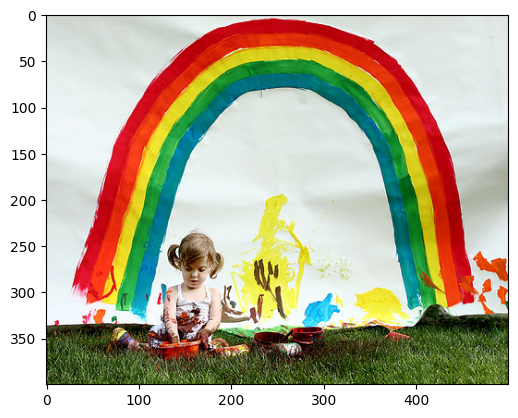

Caption: A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
Caption: A little girl is sitting in front of a large painted rainbow .
Caption: A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .
Caption: There is a girl with pigtails sitting in front of a rainbow painting .
Caption: Young girl with pigtails painting outside in the grass .


In [22]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# sigle image has 5 captions
# so, select index as : 0, 5, 10, 15, ...
data_idx = 10

image_path = data_location + "/Images/" + df.iloc[data_idx, 0]
img = mpimg.imread(image_path)
plt.imshow(img)
plt.show()

# Image contains of 5 captions
# showing all 5 captions of the image of the given idx
for i in range(data_idx, data_idx+5):
    print("Caption:", df.iloc[i, 1])


In [23]:
import os
from collections import Counter
import spacy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T

from PIL import Image

In [24]:
# using spacy for the better txt tokenization
spacy_eng = spacy.load("en_core_web_sm")
# spacy_eng = spacy.load("en_core_web_sm")

# example
txt = "This is a good place to find a city"
txt = "I'm going to New York City."   # 相比于split函数，调包可以将i'm 分解为i和'm两个部分，而split不可以。并且spacy可以把city.分解为city和. 但是split不可以。
[token.text.lower() for token in spacy_eng.tokenizer(txt)]

['i', "'m", 'going', 'to', 'new', 'york', 'city', '.']

In [25]:
class Vocabulary:
    def __init__(self, freq_threshold):
        # setting the pre-reserved(预先预订) tokens int to string tokens
        self.itos = {0:"<PAD>", 1:"<SOS>", 2:"<EOS>", 3:"<UNK>"} # PAD：填充， SOS：用于指示模型生成新句子，EOS：表示句子的结束，UNK：代表词汇表中未包含的单词

        # string to int tokens
        # its reverse dict self.itos
        self.stoi = {v:k for k, v in self.itos.items()}

        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)
    
    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in spacy_eng.tokenizer(text)]
    
    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1

                # add the word to the vocab if reaches minum frequecy threshold
                if frequencies[word] == self.freq_threshold: # 这里太妙了，使用等号而不是大于。因为如果是大于的话，还需要去重。
                    self.itos[idx] = word
                    self.stoi[word] = idx
                    idx += 1

    def numericalize(self, text):
        """
        For each word in the text corresponding index token for that word from the vocab built as list
        """
        tokenized_text = self.tokenize(text)
        return [self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text]



In [26]:
# testing the vicab class
v = Vocabulary(freq_threshold=1)

v.build_vocab(["This is a good place to find a city"])
print(v.stoi)
print(v.numericalize("This is a good place to find a city here!!"))

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'this': 4, 'is': 5, 'a': 6, 'good': 7, 'place': 8, 'to': 9, 'find': 10, 'city': 11}
[4, 5, 6, 7, 8, 9, 10, 6, 11, 3, 3, 3]


In [27]:
class FlickrDataset(Dataset):
    """
    FlickrDataset   
    """
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform

        # Get image and caption colum from the dataframe
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist()) #这里tolist好呀，就把series对象变成了list了

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        caption = self.captions[index]
        img_name = self.imgs[index]
        img_location = os.path.join(self.root_dir, img_name)
        img = Image.open(img_location).convert("RGB")

        #apply the transformation to the image
        if self.transform is not None:
            img = self.transform(img)

        # numericalize the caption text
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]

        return img, torch.tensor(caption_vec)

In [28]:
#defing the transform to be applied
transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

In [29]:
def show_image(inp, title=None):
    """Imshow for Tensor"""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

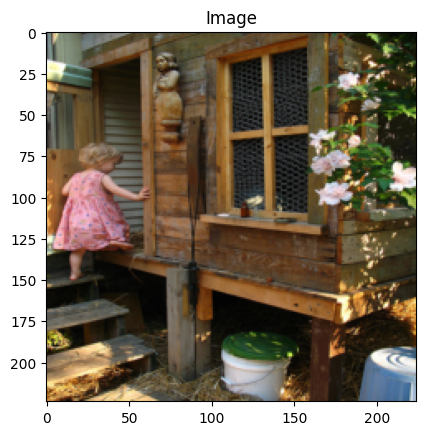

Token tensor([  1,   4,  28,   8,   4, 195, 151,  17,  32,  67,   4, 353,  11, 711,
          8,  24,   3, 496,   5,   2])
Setence:
['<SOS>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', '<UNK>', 'way', '.', '<EOS>']


In [30]:
dataset = FlickrDataset(
    root_dir= data_location +"/Images",
    captions_file= data_location +"/captions.txt",
    transform=transforms
)

img, caps = dataset[0]
show_image(img, "Image")
print("Token", caps)
print("Setence:")
print([dataset.vocab.itos[token] for token in caps.tolist()])

In [31]:
class CapsCollate:
    """
    Collate to apply the padding to the captions with dataloader
    为了batch的时候，所有数据都是一样大的，需要用Collate
    """
    def __init__(self, pad_idx, batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first

    def __call__(self, batch):
        # batch: list of tuples (img, caption)
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)  # 这样就把batch的维度给添加上来了

        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        # pad_sequence 的输入是一个序列的列表[seq1, seq2, ...] seq是一个pytorch张量。  batch_first是一个布尔值，用于指定批次索引是否在第一个维度。

        return imgs, targets


In [32]:
# writing the dataloader
# setting the costants
BATCH_SIZE = 4
NUM_WORKER = 1

# token to represent the padding
pad_idx = dataset.vocab.stoi["<PAD>"]

data_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx, batch_first=True)
)

# 准备模型

In [33]:
# 更新show_image

def show_image(inp, title=None):
    """Imshow for Tensor"""

    # unnormalize
    inp[0] = inp[0] * 0.229
    inp[1] = inp[1] * 0.224
    inp[2] = inp[2] * 0.225
    inp[0] += 0.485
    inp[1] += 0.455
    inp[2] += 0.406

    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

In [34]:
BATCH_SIZE = 256
NUM_WORKER = 4

# defining the transform to be applied
transforms = T.Compose([
    T.Resize(226),
    T.RandomCrop(224),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# T.Normalize 中第一个元组是每个通道的均值（mean），分别对应 RGB 通道。第二个元组 (0.229, 0.224, 0.225) 是每个通道的标准差（std），也分别对应 RGB 通道。
# 这些数值是基于 ImageNet 数据集计算得到的全局均值和标准差

# testing the dataset class
dataset = FlickrDataset(
    root_dir= data_location + "/Images",
    captions_file= data_location + "/captions.txt",
    transform=transforms
)

# wirting the dataloader
data_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx, batch_first=True)
)

#vocab_size = len(dataset.vocab)

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [35]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import TransformerDecoder, TransformerDecoderLayer

import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50
import math

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        modules = list(resnet.children())[:-2]  # 去掉最后一个全连接层
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size) # 这里的feature的维度一定要和query的维度一致，所以加了一个全连接。

    def forward(self, images):
        features = self.resnet(images)  # (batch_size, 2048, 7, 7)
        features = features.permute(0, 2, 3, 1) # (batch_size, 7, 7, 2048)
        features = features.view(features.size(0), -1, features.size(-1)) # (batch_size, 49, 2048)  # reshape as (batch_size, num_features, feature_dim)
        features = self.embed(features) # (batch_size, num_features, embed_size)

        return features
    
class PositionalEncoding(nn.Module):
    # 位置编码
    def __init__(self, num_hiddens, dropout, max_len= 100):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1) / torch.pow(
            10000, torch.arange(0, num_hiddens, 2, dtype=torch.float32) / num_hiddens
        )
        P[:, :, 0::2] = torch.sin(X)
        P[:, :, 1::2] = torch.cos(X)
        self.register_buffer('pe', P)

    def forward(self, X):
        #X: [batch_size, num_steps, dim]
        X = X + self.pe[:, :X.shape[1], :].to(X.device)
        return self.dropout(X) # 使用dropout来避免模型对P（位置编码）太敏感
    

def sequence_mask(X, valid_lens, value=0):  # valid_lens 就是对keys和values进行掩蔽的。
    """
    在序列中屏蔽不相关的项
    """
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_lens[:, None]
    X[~mask] = value
    return X



def masked_softmax(X, valid_lens=None):
    """
    在某些情况下，并非所有的值都应该被纳入到注意力池化中。例如文本序列中的<PAD>。
    通过最后一个轴上掩蔽元素来执行softmax操作
    """
    if valid_lens is None:
        return F.softmax(X, dim=-1)
    else:
        shape = X.shape
        # print("valid lens shape:", valid_lens.shape)
        if valid_lens.dim() == 1:
            # repeat() 是复制整个张量，而 repeat_interleave() 是逐元素重复。例如，x.repeat(2) 的结果是 [1,2,3,1,2,3]，而 x.repeat_interleave(2) 的结果是 [1,1,2,2,3,3]
            valid_lens = torch.repeat_interleave(valid_lens, shape[1]) # 如果valid_lens是标量，那么就认为所有的句子长度都是这个标量，故填充成为1维向量。
        else:
            valid_lens = valid_lens.reshape(-1)  # flatten成为1维度向量
        # 最后一个轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax的结果为0
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=1e-6)
        return F.softmax(X.reshape(shape), dim=-1)
    

class DotProductAttention(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens=None):
        """
        queries: [batch, num_steps, hidden_dim]
        keys: [batch, m_keys, hidden_dim]
        values: [batch, m_keys, vocab_dim]
        """
        attention_scores = torch.bmm(queries, keys.transpose(2, 1)) / math.sqrt(queries.shape[-1])
        alpha = masked_softmax(attention_scores, valid_lens) # [batch, num_steps, m_keys]
        return torch.bmm(self.dropout(alpha), values) # [batch, num_steps, vocab_dim]
    

def transpose_qkv(X, num_heads):
    # 虽然多头注意力模型写的是每个之前都有一个全连接，但是我们可以只写一个全连接，之后分成不同的头
    # X: [batch, num_keys, num_hiddens] => [batch*num_heads, num_keys， num_hiddens/num_heads]
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)
    X = X.permute(0, 2, 1, 3)
    return X.reshape(-1, X.shape[2], X.shape[3])

def transpose_output(X, num_heads):
    # X: [batch*num_heads, 查询的个数， num_hiddens/num_heads] => [batch, 查询的个数， num_hiddens]
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)


class MultiHeadAttention(nn.Module):
    def __init__(self, query_size, key_size, value_size, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super().__init__()
        # self.dropout = nn.Dropout(dropout)
        self.num_heads = num_heads
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias) # q, k, v首先需要先做投影，之后再做自注意力池化
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)
        self.attention = DotProductAttention(dropout)

    
    def forward(self, queries, keys, values, valid_lens):
        """
        queries, keys, values的形状 #[batch, 查询或者“键-值”的个数， num_hiddens]
        valid_lens 的形状： [batch] 或者 [batch, 查询的个数]
        经过变换之后：
        queries, keys, values的形状 #[batch*num_heads, 查询或者“键-值”的个数， num_hiddens/num_heads]
        """
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0
            )

        # output: [batch*num_heads, 查询的个数， num_hiddens/num_heads]
        output = self.attention(queries, keys, values, valid_lens) # head和batch合并之后，就可以直接用到一个attention里面了，就是用一个bmm就可以计算了。

        output_concat = transpose_output(output, self.num_heads)

        return self.W_o(output_concat)
    
    @property
    def attention_weights(self):
        return None  #TODO： 这里添加一下
    

class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络"""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,dropout=0.1, **kwargs):
        super().__init__()
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        # X: [batch, num_steps, ffn_num_input] => [batch, num_steps, ffn_num_outputs]
        return self.dense2(self.dropout(self.relu(self.dense1(X))))
    
    
class AddNorm(nn.Module):
    def __init__(self, normalize_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalize_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)
    

class DecoderBlock(nn.Module):
    def __init__(self, query_size, key_size, value_size, num_hiddens, normalize_shape,
                 ffn_num_input, ffn_num_hiddens, num_heads, dropout, i, bias=False, **kwargs):
        super().__init__()
        self.i = i #解码器中第i个块
        self.masked_attention = MultiHeadAttention(query_size, key_size, value_size, num_hiddens, num_heads, dropout, bias)
        self.addnorm1 = AddNorm(normalize_shape, dropout)
        self.attention = MultiHeadAttention(query_size, key_size, value_size, num_hiddens, num_heads, dropout, bias)
        self.addnorm2 = AddNorm(normalize_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(normalize_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]  # 在我们这个图像描述任务中，由于feature是没有<PAD>的，所以不需要encoder_valid_lens的mask
        # 训练阶段，输出序列的所有词元都在同一时间处理
        # 因此state[2][self.i]初始化为None
        # 预测阶段，输出序列是通过词元一个接着一个解码的
        # 因此state[2][self.i]包含着直到当前时间步第i个块解码的输出表示。
        if state[2][self.i] is None:  # 在training的时候，state[2][self.i] 总是None
            key_values = X # 训练
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)  #在time_step的维度进行拼接
        state[2][self.i] = key_values

        # 在训练的时候对于自注意力模块需要使用masked self-attention
        if self.training:
            batch_size, num_steps, _ = X.shape
            # print(f"batch size i geted {batch_size}, X shape is {X.shape}")
            dec_valid_lens = torch.arange(1, num_steps+1, device=X.device).repeat(batch_size, 1)  # 训练的时候用的下三角矩阵
            # print(f"dec_valid_lens shape is {dec_valid_lens.shape}")
        else:
            dec_valid_lens = None
        
        Y = self.addnorm1(X, self.masked_attention(X, key_values, key_values, dec_valid_lens))
        Z = self.addnorm2(Y, self.attention(Y, enc_outputs, enc_outputs, enc_valid_lens))
        return self.addnorm3(Z, self.ffn(Z)), state
    
    
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, query_size, key_size, value_size, num_hiddens, normalize_shape,
                 ffn_num_input, ffn_num_hiddens, num_heads, num_layers, dropout, bias=False, **kwargs):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                                 DecoderBlock(query_size, key_size, value_size, num_hiddens, normalize_shape, 
                                              ffn_num_input, ffn_num_hiddens, num_heads, dropout, i, bias))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # 解码器自注意力权重
            # self._attention_weights[0][i] = blk.masked_attention.attention.attention_weights
            # "编码器-解码器"自注意力权重
            # self._attention_weights[1][i] = blk.attention.attention.attention_weights

        return self.dense(X), state
    
    @property
    def attetion_weights(self):
        return self._attention_weights

In [37]:
class TransformerModel(nn.Module):
    def __init__(self, embed_size, vocab_size, d_model, nhead, num_layers, dim_feedforward, max_seq_length=20):
        super(TransformerModel, self).__init__()
        self.encoder = EncoderCNN(embed_size)
        self.transformer_decoder = TransformerDecoder(vocab_size, embed_size, embed_size, embed_size, embed_size, [embed_size], embed_size, dim_feedforward, nhead, num_layers, 0.1, False)
        self.max_seq_length = max_seq_length
        self.vocab_size = vocab_size

    def forward(self, images, captions):
        encoded_images = self.encoder(images)  # (batch_size, num_features, embed_size)

        dec_state = self.transformer_decoder.init_state(encoded_images, None)
        output, state = self.transformer_decoder(captions, dec_state)
        return output

    def generate(self, images, vocab, max_len=20):
        encoded_images = self.encoder(images)  # (batch_size, num_features, embed_size)

        # Start with <SOS> token
        dec_X = torch.LongTensor([[vocab.stoi["<SOS>"]]]).to(images.device)#[ 1, 1] 分别表示[batch_size, num_steps]
        
        dec_state = self.transformer_decoder.init_state(encoded_images, None)

        attentions = []
        output_seq = []
        for _ in range(max_len - 1):
            output, dec_state = self.transformer_decoder(dec_X, dec_state) # output: [1, num_steps, vocab_size] # 应该是 [1, 1, vocab_size]
            next_token = output.argmax(2)[:, -1].unsqueeze(1)  # next_token: [1, 1]
            dec_X = next_token

            # attentions.append(self.transformer_decoder.layers[-1].self_attn.attn_output_weights.detach().cpu().numpy())

            # output, _ = self.transformer_decoder(dec_X, dec_state) # output: [1, num_steps, vocab_size] # 应该是 [1, num_steps, vocab_size]
            # next_token = output.argmax(2)[:, -1].unsqueeze(1)  # next_token: [1, 1]
            # dec_X = torch.cat([dec_X, next_token], dim=1)

            # 温度采样示例
            temperature = 0.7
            logits = output[:, -1, :] / temperature
            probabilities = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probabilities, num_samples=1)
            dec_X = next_token


            # Stop if <EOS> is generated
            if next_token.item() == vocab.stoi["<EOS>"]:
                break
            output_seq.append(vocab.itos[next_token.item()])

        return output_seq, attentions

/home/liuzh/anaconda3/envs/DL/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/liuzh/anaconda3/envs/DL/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/25], Step [100/159], Loss: 5.2823
检查一下训练到底好不好
ground truth： a little child reaches for a bar . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
predict sentence： a a a a a a a a a a a a a a a a a a a a a a a a a a


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0009999573..1.0].


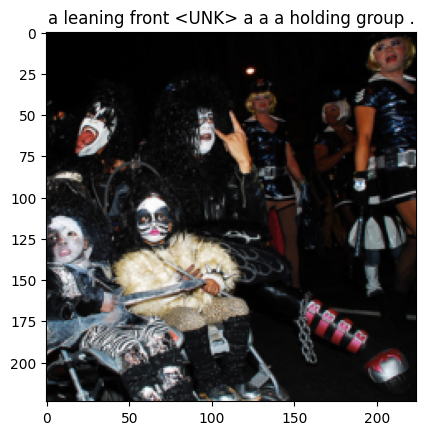

Epoch [2/25], Step [100/159], Loss: 4.0092
检查一下训练到底好不好
ground truth： young man with cap and <UNK> coat stands before building . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
predict sentence： two and and man and and and and and . . <EOS> . . . . . . . . . . . . . .


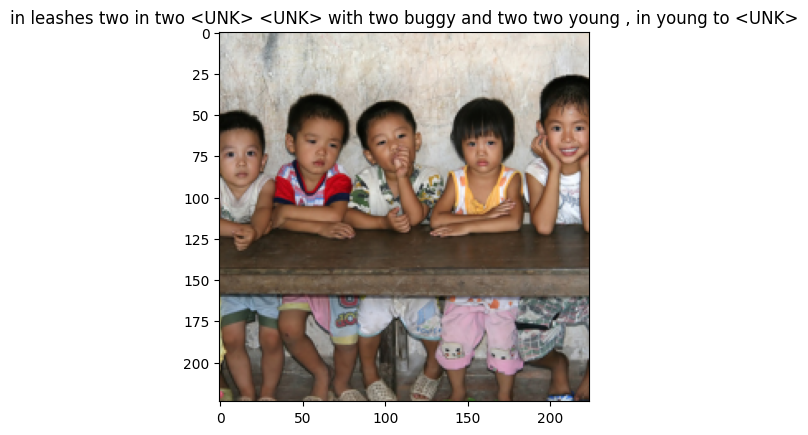

Epoch [3/25], Step [100/159], Loss: 3.5056
检查一下训练到底好不好
ground truth： several people shop at an outdoor <UNK> 's market on a cloudy day . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
predict sentence： two <UNK> <UNK> on <UNK> <UNK> <UNK> on of on a <UNK> . . <EOS> . . . . . . . . . . . . . . . . . . . .


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0009999573..1.0].


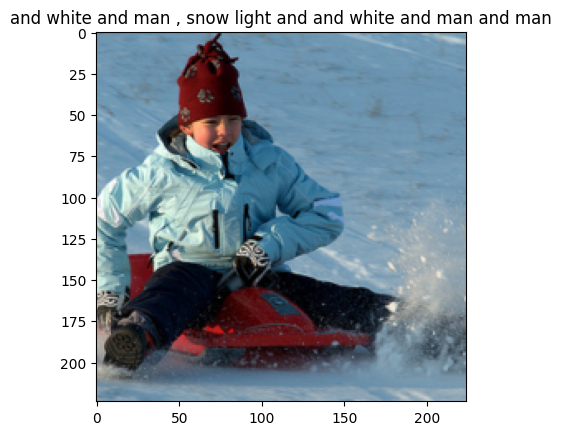

Epoch [4/25], Step [100/159], Loss: 3.0059
检查一下训练到底好不好
ground truth： kids playing in the water in front of a wooden bridge . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
predict sentence： three in in the air in a of a field . . <EOS> . . . . . . . . . . . . . . . . . . .


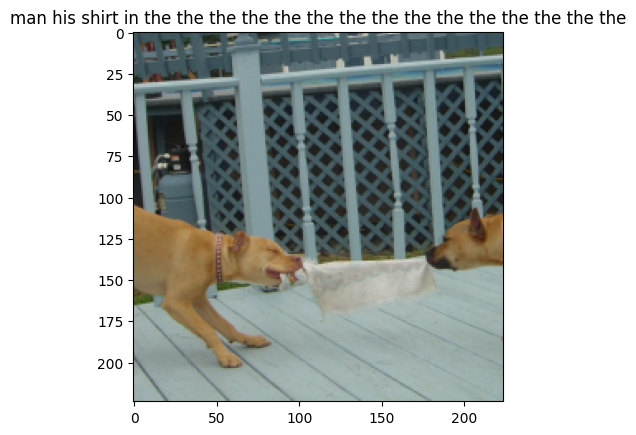

Epoch [5/25], Step [100/159], Loss: 2.6820
检查一下训练到底好不好
ground truth： two dogs walk in a body of water . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
predict sentence： two dogs are in a pool of water . <EOS> . . . . . . . . . . . . . . of


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0009999573..0.9882353].


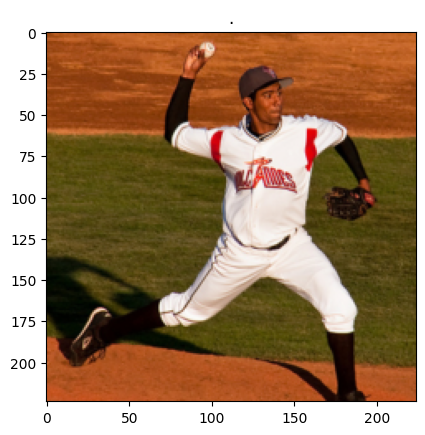

Epoch [6/25], Step [100/159], Loss: 2.6253
检查一下训练到底好不好
ground truth： two little girls playing on the parallel bars . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
predict sentence： two children children on on the street . . <EOS> <EOS> . <EOS> <EOS> . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> . . . <EOS> <EOS> . . <EOS> . <EOS> <EOS> . <EOS> .


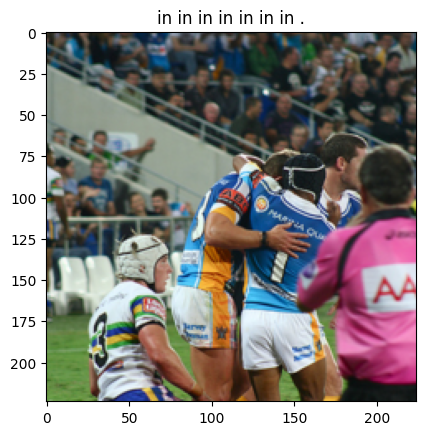

Epoch [7/25], Step [100/159], Loss: 2.3590
检查一下训练到底好不好
ground truth： the boy in the blue jacket and grey cap is playing with a ball . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
predict sentence： the boy in the blue and and is is is running with a ball . <EOS> . <EOS> . . . . <EOS> . . . . <EOS> .


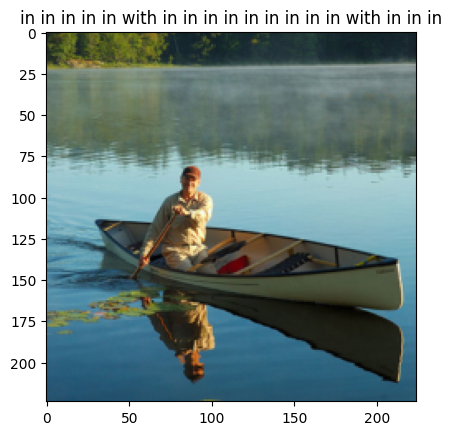

Epoch [8/25], Step [100/159], Loss: 2.0740
检查一下训练到底好不好
ground truth： a guy racing his motorcycle . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
predict sentence： a motorcycle his his bike . <EOS> <EOS> <EOS> . <EOS> <EOS> <EOS> <EOS> . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>


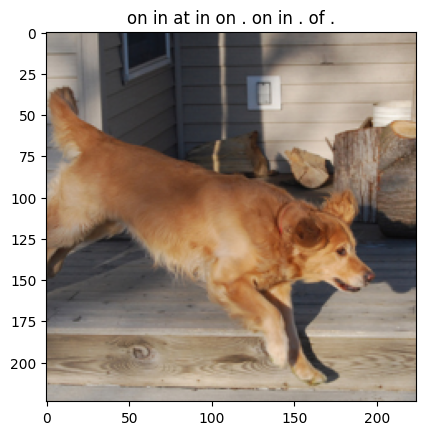

KeyboardInterrupt: 

In [38]:
# Hyperparameters
embed_size = 256
d_model = 256
nhead = 1
num_layers = 6
dim_feedforward = 512
learning_rate = 1e-4
num_epochs = 25
batch_size = 256

# Initialize model
vocab_size = len(dataset.vocab)
model = TransformerModel(embed_size, vocab_size, d_model, nhead, num_layers, dim_feedforward).to(device)

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LayerNorm):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)

model.apply(init_weights)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 加载保存的权重
# if os.path.exists('mine_transformer_model.pth'):
#     checkpoint = torch.load('mine_transformer_model.pth')
#     # 如果pth保存的时候是有字典内容的话，就这样写
#     # model.load_state_dict(checkpoint['state_dict'])
#     # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#     # start_epoch = checkpoint.get('epoch', 0)
#     # print(f"恢复训练从第 {start_epoch} 轮开始")
#     model.load_state_dict(checkpoint)
#     print(f"mine_transformer_model.pth恢复训练")

# Training loop
for epoch in range(num_epochs):
    for batch_idx, (images, captions) in enumerate(data_loader):
        images = images.to(device)
        captions = captions.to(device)

        # Forward pass
        outputs = model(images, captions[:, :-1]) # outputs: [batch, num_steps, vocab_size]
        bake_output = outputs[0].argmax(1)

        outputs = outputs.reshape(-1, outputs.size(2))
        targets = captions[:, 1:].reshape(-1)  # Exclude <SOS> token
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch_idx+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(data_loader)}], Loss: {loss.item():.4f}')

            print("检查一下训练到底好不好")
            print("ground truth：", ' '.join([dataset.vocab.itos[token.item()] for token in captions[0][1:]]))
            print("predict sentence：", ' '.join([dataset.vocab.itos[token.item()] for token in bake_output]))

            # generate the caption
            model.eval()
            with torch.no_grad():
                dataiter = iter(data_loader)
                img, _ = next(dataiter)
                generated, _ = model.generate(img[0:1].to(device), dataset.vocab, max_len=20)
                
                caption =  ' '.join(generated)
                show_image(img[0], title=caption)

            model.train()

    # Save model checkpoint
    torch.save(model.state_dict(), f'mine_transformer_model.pth')

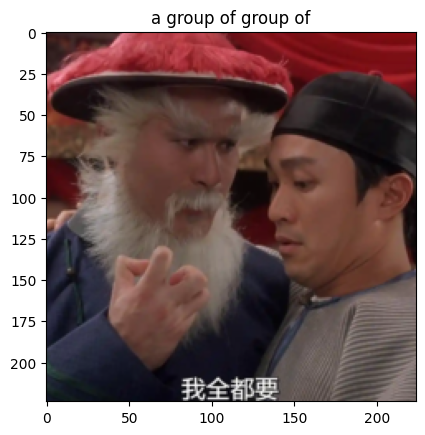

Generated Caption: a group of group of


In [ ]:
def generate_caption(image_path, model, vocab, transform, max_len=20):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        generated, _ = model.generate(image, vocab, max_len=max_len)
    
    
    caption =  ' '.join(generated)
    show_image(image[0].cpu(), title=caption)
    return caption
    

# Example usage
test_image_path = "/home/liuzh/下载/377adab44aed2e73421ef592ec7f378486d6fa23.webp"
test_image_path = "/home/liuzh/下载/src=http___img.nga.178.com_attachments_mon_201910_14_-cckxQ5-lbq1ZhT3cS1hc-u0.jpg&refer=http___img.nga.178.webp"
# test_image_path = "/home/liuzh/下载/ff41d9f436d98a5d6a17e822573e107e24a89361.jpg"
transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

caption = generate_caption(test_image_path, model, dataset.vocab, transform)
print("Generated Caption:", caption)